# *Deep Learning and Neural Networks - Coursework*

Author: Oliver Payne

ID: 200269948

# Import Python Packages and Other functionalities

In [ ]:
%matplotlib inline

# Prevents PyTorch hogging too much memory
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import time

from keras.datasets import cifar10


# check if CUDA is available
gpu = torch.cuda.is_available()
if gpu == True:
    print('GPU is available!  Running on GPU ...')
else:
    print('GPU is not available.  Running on CPU ...')


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

GPU is available!  Running on GPU ...
Using cuda.


# Load the Dataset

In [ ]:
def load_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))

    # Normalize the dataset using the mean and standard deviation for CIFAR-10.
    trans.append(torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    trans = torchvision.transforms.Compose(trans)

    # Load the cifar10 dataset for training
    cifar10_train = torchvision.datasets.CIFAR10(root="./data", train=True,
                                                 transform=trans, download=True)
    # Load the cifar10 dataset for testing
    cifar10_test = torchvision.datasets.CIFAR10(root="./data", train=False,
                                                transform=trans, download=True)

    # Load the datasets into pinned memory
    train_CIFAR10 = torch.utils.data.DataLoader(cifar10_train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_CIFAR10  = torch.utils.data.DataLoader(cifar10_test, batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_CIFAR10, test_CIFAR10

In [ ]:
# Define the batch size
batch_size = 128

# Create Training and Test datasets
train_iter, test_iter = load_cifar10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Requests the first training batch and shows its size
# Size should show batch size (e.g, 128) of b images represented by a tensor of shape 3 x 224 x 224
X, y = next(iter(train_iter))
print(X.size())
print(y.size())
print("")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 3, 32, 32])
torch.Size([128])



# Intermediate Block

In [ ]:
'''
class IntermediateBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_layers =  3, stride =  1, kernel_size =  3):
        super(IntermediateBlock, self).__init__()

        # Calculate Padding
        p = (kernel_size - 1) // 2

        # Defines a dynamic number of convolutional layers.
        self.convs = torch.nn.ModuleList([
            torch.nn.Conv2d(input_channels, output_channels, kernel_size, padding = p, stride = stride)
            for layer in range(num_layers)
        ])
        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm2d(output_channels)
            for _ in range(num_layers)
        ])

        self.relu = torch.nn.ReLU()

        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        # This linear layer outputs a vector of size `num_layers`
        self.connected_a = torch.nn.Linear(input_channels, num_layers)

    def forward(self, x):
        m = self.global_avg_pool(x)
        m = m.view(x.size(0), -1)

        a = self.connected_a(m)
        a = torch.sigmoid(a)  # Ensure a is in the range [0, 1]
        a = a.unsqueeze(-1).unsqueeze(-1)  # Reshape for broadcasting: [batch_size, num_layers, 1, 1]

        outputs = []
        # For each conv layer in num_layers.
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):


            out = torch.nn.functional.relu(bn(conv(x)))

            # Apply scaling factor 'a' corresponding to each convolutional output
            # Select the i-th element of 'a' for each sample in the batch and apply it
            out = out * a[:, i:i+1, :, :]
            outputs.append(out)

        # Sum the scaled outputs to produce the final output of the block
        out = sum(outputs)

        return out
'''

"\nclass IntermediateBlock(torch.nn.Module):\n    def __init__(self, input_channels, output_channels, num_layers =  3, stride =  1, kernel_size =  3):\n        super(IntermediateBlock, self).__init__()\n\n        # Calculate Padding\n        p = (kernel_size - 1) // 2\n\n        # Defines a dynamic number of convolutional layers.\n        self.convs = torch.nn.ModuleList([\n            torch.nn.Conv2d(input_channels, output_channels, kernel_size, padding = p, stride = stride)\n            for layer in range(num_layers)\n        ])\n        self.bns = torch.nn.ModuleList([\n            torch.nn.BatchNorm2d(output_channels)\n            for _ in range(num_layers)\n        ])\n\n        self.relu = torch.nn.ReLU()\n\n        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))\n        # This linear layer outputs a vector of size `num_layers`\n        self.connected_a = torch.nn.Linear(input_channels, num_layers)\n\n    def forward(self, x):\n        m = self.global_avg_pool(x)\n    

In [ ]:
class IntermediateBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_layers =  3, stride =  1, kernel_size =  3):
        super(IntermediateBlock, self).__init__()

        # Calculate Padding
        p = (kernel_size - 1) // 2


        # Defines a dynamic number of convolutional layers.
        self.convs = torch.nn.ModuleList([
            torch.nn.Conv2d(input_channels, output_channels, kernel_size, padding = p, stride = stride)
            for layer in range(num_layers)
        ])
        # Define dynamic number of batch normalisations (same as conv layer)
        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm2d(output_channels)
            for _ in range(num_layers)
        ])

        # Activation Layer and pooling
        self.relu = torch.nn.ReLU()
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Linear layer outputs a vector of size `num_layers` for "a"
        self.connected_a = torch.nn.Linear(input_channels, num_layers)

    def forward(self, x):
        # Get m
        m = self.global_avg_pool(x)
        m = m.view(x.size(0), -1)

        # Get a
        a = self.connected_a(m)
        a = torch.sigmoid(a)  # Ensure a is in the range [0, 1]
        a = a.unsqueeze(-1).unsqueeze(-1)  # Reshape for broadcasting: [batch_size, num_layers, 1, 1]

        outputs = []
        # For each conv layer in num_layers.
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):

            out = conv(x)
            out = bn(out)
            out = self.relu(out)

            # Apply scaling factor 'a' corresponding to each convolutional output
            # Select the i-th element of 'a' for each sample in the batch and apply it
            out = out * a[:, i:i+1, :, :]
            outputs.append(out)

        # Sum the scaled outputs to produce the final output of the block
        out = sum(outputs)

        return out

# Output Block

In [ ]:
class OutputBlock(torch.nn.Module):
    def __init__(self, input_channels, num_outputs):
        super(OutputBlock, self).__init__()

        # Define Average Pooling to flatten convolutions
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Defines interconnected linear layers
        self.linear1 = torch.nn.Linear(input_channels, input_channels * 2)
        self.linear2 = torch.nn.Linear(input_channels * 2, 4096)
        self.linear3 = torch.nn.Linear(4096, 1024)
        self.linear4 = torch.nn.Linear(1024, num_outputs)

        # Define dropout layer
        self.dropout = torch.nn.Dropout(0.2)

        self.relu = torch.nn.ReLU()


    def forward(self, x):
        m = self.global_avg_pool(x).view(x.size(0), -1)

        out = self.linear1(m)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear4(out)

        return out



# CNN implementation

In [ ]:
'''
class WyrdNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(WyrdNet, self).__init__()

        s = 1

        # Convolutional Intermediate blocks
        self.intblock1 = IntermediateBlock(3, 128, stride = s,  num_layers =  3,  kernel_size = 3)
        self.intblock2 = IntermediateBlock(128, 256, stride = s, num_layers =  3, kernel_size = 3)

        self.batchnorm1 = torch.nn.BatchNorm2d(256)
        self.relu = torch.nn.ReLU()

        self.intblock3 = IntermediateBlock(256, 1024, stride = s, num_layers =  3, kernel_size = 3)
        self.intblock4 = IntermediateBlock(1024, 1024, stride = s, num_layers =  3, kernel_size = 7)
        self.intblock5 = IntermediateBlock(1024, 512, stride = s, num_layers =  3, kernel_size = 5)

        self.batchnorm2 = torch.nn.BatchNorm2d(512)


        # Activation
        self.relu = torch.nn.ReLU()

        # Pooling layers
        self.maxpool = torch.nn.MaxPool2d(2,2)

        # Dropout Layer
        self.dropout = torch.nn.Dropout(0.2)

        # Out Layer
        self.outblock = OutputBlock(512, num_outputs)


    def forward(self, x):

        out = self.intblock1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after activation
        out = self.maxpool(out)

        out = self.intblock2(out)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after activation
        out = self.maxpool(out)

        out = self.intblock3(out)
        out = self.intblock4(out)
        out = self.intblock5(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)  # Apply dropout after activation
        out = self.maxpool(out)

        out = self.outblock(out)

        return out
'''

'\nclass WyrdNet(torch.nn.Module):\n    def __init__(self, num_outputs):\n        super(WyrdNet, self).__init__()\n\n        s = 1\n\n        # Convolutional Intermediate blocks\n        self.intblock1 = IntermediateBlock(3, 128, stride = s,  num_layers =  3,  kernel_size = 3)\n        self.intblock2 = IntermediateBlock(128, 256, stride = s, num_layers =  3, kernel_size = 3)\n\n        self.batchnorm1 = torch.nn.BatchNorm2d(256)\n        self.relu = torch.nn.ReLU()\n\n        self.intblock3 = IntermediateBlock(256, 1024, stride = s, num_layers =  3, kernel_size = 3)\n        self.intblock4 = IntermediateBlock(1024, 1024, stride = s, num_layers =  3, kernel_size = 7)\n        self.intblock5 = IntermediateBlock(1024, 512, stride = s, num_layers =  3, kernel_size = 5)\n\n        self.batchnorm2 = torch.nn.BatchNorm2d(512)\n\n\n        # Activation\n        self.relu = torch.nn.ReLU()\n\n        # Pooling layers\n        self.maxpool = torch.nn.MaxPool2d(2,2)\n\n        # Dropout Layer\n  

In [ ]:
class WyrdNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(WyrdNet, self).__init__()

        self.intblock1 = IntermediateBlock(3, 128, num_layers=3, kernel_size=3)
        self.intblock2 = IntermediateBlock(128, 256, num_layers=3, kernel_size=3)

        self.batchnorm1 = torch.nn.BatchNorm2d(256)
        self.relu = torch.nn.ReLU()

        self.intblock3 = IntermediateBlock(256, 1024, num_layers=3, kernel_size=3)
        self.intblock4 = IntermediateBlock(1024, 1024, num_layers=3, kernel_size=7)

        self.batchnorm2 = torch.nn.BatchNorm2d(1024)
        self.relu = torch.nn.ReLU()

        self.intblock5 = IntermediateBlock(1024, 2048, num_layers=3, kernel_size=5)
        self.intblock6 = IntermediateBlock(2048, 512, num_layers=3, kernel_size=5)

        self.batchnorm3 = torch.nn.BatchNorm2d(512)
        self.relu = torch.nn.ReLU()

        # Defines Maxpoooling and dropout layers
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.2)
        self.avgpool = torch.nn.AvgPool2d(8, 8)

        # Defines outblock call
        self.outblock = OutputBlock(512, num_outputs)

        # 1x1 convolution to adjust channel dimensions for skip connection
        self.adjust_channels = torch.nn.Conv2d(3, 512, 1)




    def forward(self, x):

        # Macro Block 1
        out = self.intblock1(x)
        out = self.intblock2(out)

        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)

        # Macro Block 2
        out = self.intblock3(out)
        out = self.intblock4(out)

        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)

        # Macro Block 3
        out = self.intblock5(out)
        out = self.intblock6(out)

        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)


        # Employ Skip Connection
        skip_connection = self.adjust_channels(x)
        skip_connection = self.avgpool(skip_connection)
        out += skip_connection  # Add the skip connection before the final output layer

        out = self.outblock(out)

        return out

Model creation and weight initialisation

In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10

model = WyrdNet(10).to(device) # Creates and moves the model to `device`

model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

WyrdNet(
  (intblock1): IntermediateBlock(
    (convs): ModuleList(
      (0-2): 3 x Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bns): ModuleList(
      (0-2): 3 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
    (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (connected_a): Linear(in_features=3, out_features=3, bias=True)
  )
  (intblock2): IntermediateBlock(
    (convs): ModuleList(
      (0-2): 3 x Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bns): ModuleList(
      (0-2): 3 x BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
    (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (connected_a): Linear(in_features=128, out_features=3, bias=True)
  )
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (intblock3): Inte

# Loss Function

In [ ]:
loss = torch.nn.CrossEntropyLoss()

# Optimisation Algorithm

In [ ]:
# Learning rate
lr = 0.05

# Optimiser
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Evaluation

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(dim=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))



def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

tensor(1.)
Training accuracy: 0.0870399996638298. Testing accuracy: 0.08699999749660492.


# Training


Epoch 1/10.
Training accuracy: 0.5638999938964844. Testing accuracy: 0.5546999573707581. Duration: 272.018s.

Epoch 2/10.
Training accuracy: 0.6935799717903137. Testing accuracy: 0.6694999933242798. Duration: 271.565s.

Epoch 3/10.
Training accuracy: 0.7359399795532227. Testing accuracy: 0.6984999775886536. Duration: 272.167s.

Epoch 4/10.
Training accuracy: 0.7942799925804138. Testing accuracy: 0.7425000071525574. Duration: 270.962s.

Epoch 5/10.
Training accuracy: 0.7837599515914917. Testing accuracy: 0.7210999727249146. Duration: 268.175s.

Epoch 6/10.
Training accuracy: 0.8251799941062927. Testing accuracy: 0.7542999982833862. Duration: 272.425s.

Epoch 7/10.
Training accuracy: 0.8601599931716919. Testing accuracy: 0.7742999792098999. Duration: 271.936s.

Epoch 8/10.
Training accuracy: 0.8340599536895752. Testing accuracy: 0.7364999651908875. Duration: 268.545s.

Epoch 9/10.
Training accuracy: 0.8946999907493591. Testing accuracy: 0.7770999670028687. Duration: 272.334s.

Epoch 10/

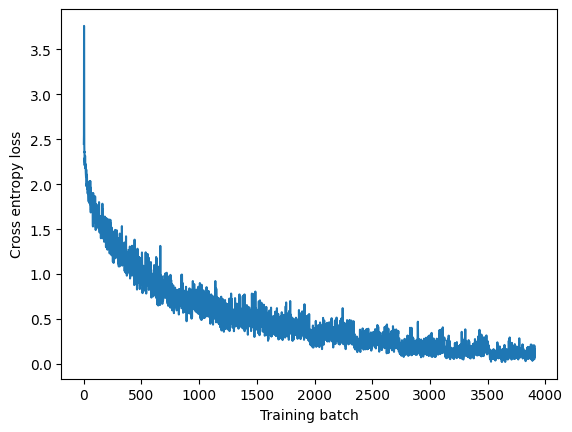

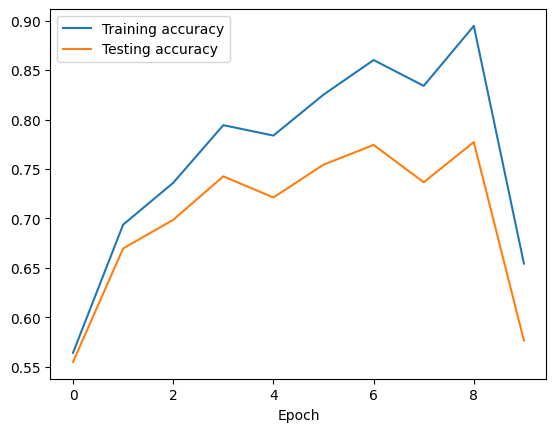

In [ ]:
# Setup
losses = []  # Stores the loss for each training batch
train_accs = []  # Stores the training accuracy after each epoch
test_accs = []  # Stores the testing accuracy after each epoch

num_epochs = 10
patience = 3  # How many epochs to wait after last time validation loss improved.
best_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train()  # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)  # Moves data to `device`
        logits = model(X)  # Computes the logits for the batch of images `X`

        l = loss(logits, y)  # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad()  # Zeroes the gradients stored in the model parameters
        l.backward()  # Computes the gradient of the loss `l` with respect to the model parameters
        optimizer.step()  # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l))  # Stores the loss for this batch

    # Evaluation without gradient calculation
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        train_accuracy = evaluate_metric(model, train_iter, correct)
        test_accuracy = evaluate_metric(model, test_iter, correct)
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)

    # Early stopping logic
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model if desired
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    end_time = time.perf_counter()
    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.')

# Plotting
plt.plot(losses)
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()


Epoch 1/1.
Training accuracy: 0.9562199711799622. Testing accuracy: 0.821899950504303. Duration: 271.696s.


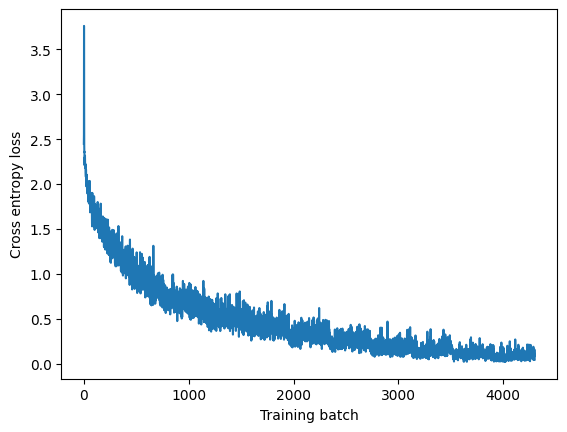

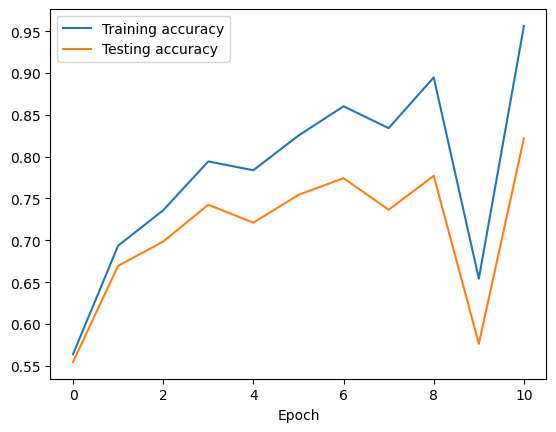

In [ ]:
num_epochs = 1
patience = 3  # How many epochs to wait after last time validation loss improved.
best_acc = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train()  # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)  # Moves data to `device`
        logits = model(X)  # Computes the logits for the batch of images `X`

        l = loss(logits, y)  # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad()  # Zeroes the gradients stored in the model parameters
        l.backward()  # Computes the gradient of the loss `l` with respect to the model parameters
        optimizer.step()  # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l))  # Stores the loss for this batch

    # Evaluation without gradient calculation
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        train_accuracy = evaluate_metric(model, train_iter, correct)
        test_accuracy = evaluate_metric(model, test_iter, correct)
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)

    # Early stopping logic
    if test_accuracy > best_acc:
        best_acc = test_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model if desired
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    end_time = time.perf_counter()
    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.')

# Plotting
plt.plot(losses)
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()